In [1]:
base_path = "results_updated"


In [14]:
!tar -zxf {base_path}.tar.gz

In [2]:
import os, json
from collections import defaultdict

SCORES = []

params = defaultdict(set)
for base_folder, folders, files in os.walk(base_path):
    if files:
        date, rest = base_folder.split('/')[-1].split('-')
        time, time_suf, lang, smth, cat = rest.split('_')
        for file in files:
            dat = json.load(open(f"{base_folder}/{file}"))

            for k, v in dat["params"].items():
                if type(v) is str: params[k].add(v)
            xs = list(dat["results"]["test_score"].keys())
            ys = [el[0] for el in dat["results"]["test_score"].values()]
            score = dat["params"].copy()
            score["coord"] = xs
            score["score"] = ys
            SCORES.append(score)


In [3]:
len(SCORES)

2046

In [4]:
from itertools import product
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict
import random


CATEGORICAL_T = "categorical"
CONTINUOUS_T = "continuous"


In [5]:
task2type = {}
for probing_type in params["probing_type"]:
    categorical_ = input(f"is \"{probing_type}\" a categorical probing task? [Y/N]: ")
    if categorical_.lower().startswith('y'):
        type_ = CATEGORICAL_T
    else:
        type_ = CONTINUOUS_T
    task2type[probing_type] = type_

is "layer" a categorical probing task? [Y/N]:  N


In [6]:
axes2type = defaultdict(lambda: "continuous")
from itertools import cycle
colors = cycle(["#b6e1fc","#ccccff","#ede1ed","#d8ebd1"])

lev2col = defaultdict(lambda: next(colors))


CNT = 0
CHARTS = []
POOR_COORDS = []
GOOD_COORDS = set()

facet_values = defaultdict(set)
for score in SCORES:
    for facet_type in score:
        facet_value = score[facet_type]
        if type(facet_value) is dict: continue
        if type(facet_value) is list: facet_value=tuple(facet_value)
        facet_values[facet_type].add(facet_value)

def barchart(x_ax, y_ax, scores, reference_ordering=None):
    """takes the axes labels, exps results and (optional) ordering
    returns the properly ordered <x,y> points
    """
    xy_pairs = [(res[x_ax], res[y_ax]) for res in scores]
    
    if reference_ordering is None and axes2type[x_ax] == CATEGORICAL_T:
        xy_pairs = sorted(xy_pairs, key=lambda tup: tup[1])
    elif reference_ordering:
        xy_di = dict(xy_pairs)
        xy_pairs = [(x, xy_di[x]) for x in reference_ordering]
    if xy_pairs:
        xs, ys = zip(*xy_pairs)
    else: xs, ys = [], []
    return np.array(xs).flatten(), np.array(ys).flatten()

def matches_restriction(score, restriction):
    return all(score[k] == v for k,v in restriction.items())

def histogram_html(x_ax, y_ax, facet_coords):
    
    global SCORES, CHARTS, CNT, POOR_COORDS
    scores_to_plot = [score for score in SCORES if matches_restriction(score, facet_coords)]
    xs, ys = barchart(x_ax, y_ax, scores_to_plot)

    if len(xs):
        CHARTS.append({"coord": facet_coords.copy(), "xs": xs, "ys": ys})
        GOOD_COORDS.add(str(facet_coords))
    else:
        POOR_COORDS.append(facet_coords)
    CNT +=1
    if CNT % 100 == 0:
        print(CNT, end = ' ')
        if CNT % 1000 == 0:
            print()
    return ''

    
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.bar(xs, ys)
    fig.suptitle(''.join(f"{k}={v}" for k,v in facet_coords.items()))
    ax.set_xlabel(x_ax)
    ax.set_ylabel(SCORES[0]["metric_name"])
    figfile = f"{str(datetime.now().timestamp()).replace('.','')}.jpg"
    fig.savefig(figfile)
    html_code = f'<img src="{figfile}"/>'
    return html_code

def process_facet_level(facet_level, next_levels, x_ax, y_ax, facet_coords=None):
    global SCORES
    if facet_coords is None: facet_coords = {}
    codes = []
    for facet_value in facet_values[facet_level]:
        facet_coords[facet_level] = facet_value
        if next_levels:
            nested_html = process_facet_level(next_levels[0], next_levels[1:], x_ax, y_ax, facet_coords)
        else:
            nested_html = histogram_html(x_ax, y_ax, facet_coords)
        codes.append(f"<div id='{facet_level}-{facet_value}' style='border:1px solid black;display: grid;  grid-gap: 5px; background-color: {lev2col[facet_level]}; margin:20px'><h2>{facet_level+'='+facet_value}</h2>{nested_html}</div>")
    return ''.join(codes)




x_ax = "coord"
y_ax = "score"
facet_hierarchy = ["task_category", "task_language"]

res = process_facet_level(facet_hierarchy[0], facet_hierarchy[1:], x_ax, y_ax)
print(res, file=open("facets.html", 'w'))


100 200 300 400 500 600 700 800 900 1000 
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 
2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 
3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 
4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 
5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 
6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 
7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 
8100 8200 8300 8400 8500 8600 8700 8800 8900 

In [7]:
print(len(CHARTS))

1240


In [8]:
print(len(GOOD_COORDS))

1240


In [25]:
from itertools import product
from similaritymeasures import frechet_dist
from scipy.stats import pearsonr
from tqdm.auto import tqdm
from langcodes import Language
import json

import pandas as pd
lang2wals = pd.read_csv("Languages.csv").set_index("iso_codes")

already_scored = {}
lang2lat = {}
lang2long = {}
for left_c, right_c in tqdm(product(CHARTS, CHARTS), total=(len(CHARTS)*len(CHARTS))):
    if str(left_c['coord']) == str(right_c['coord']): continue
    if (str(left_c['coord']), str(right_c['coord'])) in already_scored: continue
    if (str(right_c['coord']), str(left_c['coord'])) in already_scored: continue
    if len(left_c['ys']) != len(right_c['ys']): continue
    
    res_di = {}
    for col, value in left_c['coord'].items(): res_di[f"left:{col}"] = value
    for col, value in right_c['coord'].items(): res_di[f"right:{col}"] = value
    
    bad_row=False
    res_di_update = {}
    for colname, value in res_di.items():
        if "task_language" in colname:
            res_di_update[colname.replace("task_language", "language")] = Language.get(value).to_alpha3()
            latitude = lang2lat.setdefault(value, lang2wals.latitude.get(Language.get(value).to_alpha3(), None))
            if "iso_codes" in str(latitude): latitude=None
            if lang2lat[value] is None: bad_row=True; break;
            longitude = lang2long.setdefault(value, lang2wals.longitude.get(Language.get(value).to_alpha3(), None))
            if "iso_codes" in str(longitude): longitude=None
            res_di_update[colname.replace("task_language", "latitude")] = latitude
            res_di_update[colname.replace("task_language", "longitude")] = longitude
    res_di.update(res_di_update)
    if bad_row: continue
    res_di["left:xs"], res_di["right:xs"] = json.dumps(left_c["xs"].tolist()), json.dumps(right_c["xs"].tolist())
    res_di["left:ys"], res_di["right:ys"] = json.dumps(left_c["ys"].tolist()), json.dumps(right_c["ys"].tolist())
    res_di["frechet"] = frechet_dist(left_c['ys'], right_c['ys'])
    res_di["pearson"] = pearsonr(left_c['ys'], right_c['ys'])
    res_di["pearson_v"] = res_di["pearson"][0]
    already_scored[(str(left_c['coord']), str(right_c['coord']))] = res_di
    

  0%|          | 0/1537600 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


KeyboardInterrupt: 

In [26]:
len(already_scored.values())

10655

In [27]:
import pandas as pd

already_scored_df = pd.DataFrame(already_scored.values()).dropna('rows', subset=["pearson_v", "left:latitude", "left:longitude", "right:language", "right:latitude", "right:longitude"])
already_scored_df

/var/folders/sw/psr8kbxs7y11tbbbb0m4ws1h0000gq/T/ipykernel_4924/1246877653.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  already_scored_df = pd.DataFrame(already_scored.values()).dropna('rows', subset=["pearson_v", "left:latitude", "left:longitude", "right:language", "right:latitude", "right:longitude"])


,left:task_category,left:task_language,right:task_category,right:task_language,left:language,left:latitude,left:longitude,right:language,right:latitude,right:longitude,left:xs,right:xs,left:ys,right:ys,frechet,pearson,pearson_v
0,Subcat,af,Subcat,quc,afr,-31.0,22.0,quc,15.00,-91.416667,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.8, 0.8, 0.8, 0.8, 0.772728725274023, 0.7517...",0.199777,"(0.29024383916911617, 0.36011379668087046)",0.290244
1,Subcat,af,SubGender,pl,afr,-31.0,22.0,pol,52.00,20.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.766735812911132, 0.7708333333333333, 0.7705...",0.119375,"(-0.3240244743300963, 0.3041924978003351)",-0.324024
2,Subcat,af,PunctType,ca,afr,-31.0,22.0,cat,41.75,2.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.6362493852964014, 0.6472436149463834, 0.654...",0.334786,"(0.5596106141617089, 0.05849629123835554)",0.559611
6,Subcat,af,Gender,br,afr,-31.0,22.0,bre,48.00,-3.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.8091603053435115, 0.8091603053435115, 0.809...",0.097577,"(0.24798474927430902, 0.4370752777159013)",0.247985
11,Subcat,af,Gender,bg,afr,-31.0,22.0,bul,42.50,25.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.6306039722916436, 0.6309751434034416, 0.630...",0.271278,"(0.005573970297842179, 0.9862833756961876)",0.005574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10649,Gender,da,Aspect,myv,dan,56.0,10.0,myv,53.00,45.500000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8278074866310161, 0.8278074866310161, 0.827...","[0.8000000000000002, 0.8000000000000002, 0.800...",0.172193,"(-0.600720279225702, 0.03886629590971709)",-0.600720
10650,Gender,da,Aspect,bej,dan,56.0,10.0,bej,18.00,36.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8278074866310161, 0.8278074866310161, 0.827...","[0.7499999999999999, 0.7499999999999999, 0.749...",0.281936,"(0.36326084557072735, 0.2457893496804566)",0.363261
10651,Gender,da,Aspect,lv,dan,56.0,10.0,lav,57.00,24.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8278074866310161, 0.8278074866310161, 0.827...","[0.9742120343839542, 0.9742120343839542, 0.974...",0.230944,"(0.6440783436861859, 0.02379428823269619)",0.644078
10652,Gender,da,Aspect,be,dan,56.0,10.0,bel,54.00,28.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8278074866310161, 0.8278074866310161, 0.827...","[0.5933715641684792, 0.5402515933440896, 0.558...",0.234436,"(-0.7090469160386907, 0.009824410419131908)",-0.709047


In [28]:
already_scored_df.to_csv("already_scored.csv", index=False)

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from matplotlib import pyplot as plt
def draw_row(row_ix):
    global already_scored_df
    row =  already_scored_df.iloc[row_ix]
    left_xs, right_xs, left_ys, right_ys = row["left:xs"], row["right:xs"], row["left:ys"], row["right:ys"]
    left_xs, right_xs, left_ys, right_ys = json.loads(left_xs), json.loads(right_xs), json.loads(left_ys), json.loads(right_ys)
    # fig, ax = plt.subplots(1,1, figsize=(10,3))
    left_dat = pd.DataFrame({"x": left_xs, "y": left_ys})
    left_dat["experiment"] = "left"
    right_dat = pd.DataFrame({"x": right_xs, "y": right_ys})
    right_dat["experiment"] = "right"
    dat = pd.concat([left_dat, right_dat])
    g = sns.catplot(data=dat, kind="bar",x="x", y="y", hue="experiment", height=3, aspect=2/1)
    g.set(title=f"{row['left:task_language']} {row['left:task_category']}{' '*8}{row['right:task_language']} {row['right:task_category']}{' '*8}frechet: {round(row['frechet'],2)} pearson: {round(row['pearson_v'],2)}")
    g.set(ylim=(0,1))

In [105]:

import pandas as pd
already_scored_df = pd.read_csv("already_scored.csv")
already_scored_df.head(2)

,left:task_category,left:task_language,right:task_category,right:task_language,left:language,left:latitude,left:longitude,right:language,right:latitude,right:longitude,left:xs,right:xs,left:ys,right:ys,frechet,pearson,pearson_v
0,Subcat,af,Subcat,quc,afr,-31.0,22.0,quc,15.0,-91.416667,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.8, 0.8, 0.8, 0.8, 0.772728725274023, 0.7517...",0.199777,"(0.29024383916911617, 0.36011379668087046)",0.290244
1,Subcat,af,SubGender,pl,afr,-31.0,22.0,pol,52.0,20.000000,"[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[""0"", ""1"", ""2"", ""3"", ""4"", ""5"", ""6"", ""7"", ""8"", ...","[0.8861111111111111, 0.8861111111111111, 0.886...","[0.766735812911132, 0.7708333333333333, 0.7705...",0.119375,"(-0.3240244743300963, 0.3041924978003351)",-0.324024


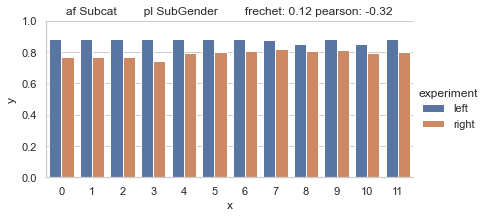

In [108]:



draw_row(1)

In [96]:
!python3 app.py

/Users/serikov/probing_dashboard/layouts/main.py:1: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/serikov/probing_dashboard/layouts/main.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
This is not supported, switching to serve_locally=True
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
/Users/serikov/probing_dashboard/layouts/main.py:1: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/Users/serikov/probing_dashboard/layouts/main.py:2: UserWarning: 
The dash_

In [19]:
already_scored_df.head()

,left:task_category,left:task_language,right:task_category,right:task_language,left:language,left:latitude,left:longitude,right:language,right:latitude,right:longitude,frechet,pearson,pearson_v
0,Strength,ro,AdpType,cs,ron,47.0,29.0,ces,50.0,15.0,0.590643,"(-0.7035433333929969, 2.4453292092321828e-08)",-0.703543
1,Strength,ro,PronType,ro,ron,47.0,29.0,ron,47.0,29.0,0.854003,"(0.8924260716458663, 1.6445290910346805e-17)",0.892426
2,Strength,ro,PronType,fi,ron,47.0,29.0,fin,62.0,25.0,0.346165,"(0.09056969586690744, 0.5404019898668735)",0.090570
3,Strength,ro,Case,ro,ron,47.0,29.0,ron,47.0,29.0,0.424951,"(0.20277324755938708, 0.16690095645841924)",0.202773
4,Strength,ro,Case,fi,ron,47.0,29.0,fin,62.0,25.0,0.715723,"(0.12247297527976228, 0.40694628580356085)",0.122473


In [23]:
CHARTS[0]

{'coord': {'task_category': 'Subcat', 'task_language': 'gun'},
 'xs': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '0',
        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
       dtype='<U2'),
 'ys': array([0.61997724, 0.63049451, 0.62061443, 0.63326586, 0.61509888,
        0.62373411, 0.63471772, 0.6129994 , 0.59301651, 0.58821254,
        0.62401258, 0.62104949, 0.71428571, 0.71428571, 0.71428571,
        0.71428571, 0.44444444, 0.55555556, 0.67532468, 0.45887446,
        0.59259259, 0.45887446, 0.67532468, 0.71428571])}